# ZIP Code
Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990).

The data is in a numpy compressed file, and each row consists of the digit id (0-9) followed by the 256 grayscale values. The last column contains is_test flag 0 for train and 1 for test observations.

There are 7291 training observations and 2007 test observations.

The test set is notoriously "difficult", and a 2.5% error rate is excellent. These data were kindly made available by the neural network group at AT&T research labs (thanks to Yann Le Cunn).

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
# load numpy array from the compressed file
arr = np.load('../data/zip.npy.npz')['arr_0']
# do train-test split by the last column
train, test = arr[arr[:, -1] == 0], arr[arr[:, -1] == 1]
X_train, X_test = train[:, 1:-1], test[:, 1:-1]
y_train, y_test = train[:, 0].astype(int), test[:, 0].astype(int)

# do one hot labels encoding
ohe = OneHotEncoder(categories='auto')
Y_train_one_hot = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
Y_test_one_hot = ohe.fit_transform(y_test.reshape(-1, 1)).toarray()

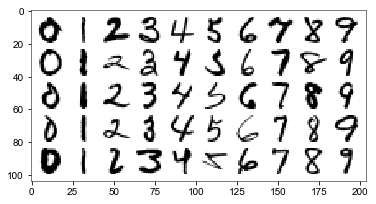

In [3]:
# PAGE 404. FIGURE 11.9. Examples of training cases from ZIP code data. Each
#           image is a 16 × 16 8-bit grayscale representation of a handwritten
#           digit.
w = 20  # pixels for one digit
result = np.ones(shape=(4+w*5, 4+w*10))
for d in range(10):
    d_idx = np.squeeze(np.argwhere(y_train == d))
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))
_ = plt.imshow(result, cmap="gray")

## Training

In [4]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [18]:
# let's write a generic training procedure
# it returns test accuracy score for each optimization step
def train(session, optimizer_step, fd_train, fd_test):
    accuracy = []
    session.run(tf.global_variables_initializer())
    for e in range(1000):
        session.run(optimizer_step, fd_train)
        y_test_hat = np.argmax(session.run(y_hat, fd_test), axis=1)
        accuracy.append(accuracy_score(y_test, y_test_hat))
        print(e, accuracy[-1])
    return accuracy

In [6]:
session = tf.Session()
initializer = tf.contrib.layers.xavier_initializer()

## Net-1
No hidden layer, equivalent to multinomial logistic regression.

In [6]:
# define placeholders for features and targets
x = tf.placeholder(tf.float64, shape=[None, 256])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([256, 10], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 10], dtype=tf.float64))
# neural network computation graph
y_hat = tf.nn.softmax(a0 + x @ A)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))
# use adam training step
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [7]:
net1_accuracy = train(
    session, 
    adm,
    {x: X_train, y: Y_train_one_hot},
    {x: X_test}
)

## Net-2
One hidden layer, 12 hidden units fully connected.

In [8]:
# define placeholders for features and targets
x = tf.placeholder(tf.float64, shape=[None, 256])
y = tf.placeholder(tf.float64, shape=[None, 10])

n_hidden = 12

A = tf.Variable(initializer([256, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 10], dtype=tf.float64))
b0 = tf.Variable(initializer([10], dtype=tf.float64))

# hidden layer
Z = tf.nn.sigmoid(a0 + x@A)
y_hat = tf.nn.softmax(b0 + Z@B)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [9]:
net2_accuracy = train(
    session, 
    adm,
    {x: X_train, y: Y_train_one_hot},
    {x: X_test}
)

## Net-3
Two hidden layers locally connected.

In [10]:
# define placeholders for features and targets
X = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

A = tf.Variable(initializer([1, 8, 8, 9], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 8, 8], dtype=tf.float64))

B = tf.Variable(initializer([1, 4, 4, 25], dtype=tf.float64))
b0 = tf.Variable(initializer([1, 4, 4], dtype=tf.float64))

C = tf.Variable(initializer([16, 10], dtype=tf.float64))
c0 = tf.Variable(initializer([10], dtype=tf.float64))

patches1 = tf.extract_image_patches(
    images=X, 
    ksizes=[1, 3, 3, 1], 
    strides=[1, 2, 2, 1], 
    rates=[1, 1, 1, 1], 
    padding='SAME'
)

Z1 = tf.expand_dims(tf.nn.sigmoid(tf.reduce_sum(patches1 * A, axis=3)+a0), -1)

patches2 = tf.extract_image_patches(
    images=Z1, 
    ksizes=[1, 5, 5, 1], 
    strides=[1, 1, 1, 1], 
    rates=[1, 1, 1, 1], 
    padding='VALID'
)

Z2 = tf.reshape(tf.nn.sigmoid(tf.reduce_sum(patches2 * B, axis=3)+b0), [-1, 16])

y_hat = tf.nn.softmax(c0 + Z2@C)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [12]:
net3_accuracy = train(
    session, 
    adm,
    {X: X_train.reshape((X_train.shape[0], 16, 16, 1)), y: Y_train_one_hot},
    {X: X_test.reshape((X_test.shape[0], 16, 16, 1))}
)

## Net-4
Two hidden layers, locally connected with weight sharing.

In [28]:
# define placeholders for features and targets
X = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

A0 = tf.Variable(initializer([1, 1, 1, 9], dtype=tf.float64))
A1 = tf.Variable(initializer([1, 1, 1, 9], dtype=tf.float64))
a00 = tf.Variable(initializer([1, 8, 8], dtype=tf.float64))
a01 = tf.Variable(initializer([1, 8, 8], dtype=tf.float64))

B0 = tf.Variable(initializer([1, 4, 4, 25], dtype=tf.float64))
B1 = tf.Variable(initializer([1, 4, 4, 25], dtype=tf.float64))
b0 = tf.Variable(initializer([1, 4, 4], dtype=tf.float64))

C = tf.Variable(initializer([16, 10], dtype=tf.float64))
c0 = tf.Variable(initializer([10], dtype=tf.float64))

patches1 = tf.extract_image_patches(
    images=X, 
    ksizes=[1, 3, 3, 1], 
    strides=[1, 2, 2, 1], 
    rates=[1, 1, 1, 1], 
    padding='SAME'
)

Z10 = tf.expand_dims(tf.nn.sigmoid(tf.reduce_sum(patches1*A0, axis=3)+a00), -1)
Z11 = tf.expand_dims(tf.nn.sigmoid(tf.reduce_sum(patches1*A1, axis=3)+a01), -1)

patches20 = tf.extract_image_patches(
    images=Z10, 
    ksizes=[1, 5, 5, 1], 
    strides=[1, 1, 1, 1], 
    rates=[1, 1, 1, 1], 
    padding='VALID'
)
patches21 = tf.extract_image_patches(
    images=Z11, 
    ksizes=[1, 5, 5, 1], 
    strides=[1, 1, 1, 1], 
    rates=[1, 1, 1, 1], 
    padding='VALID'
)


Z2 = tf.reshape(tf.nn.sigmoid(tf.reduce_sum(patches20*B0+patches21*B1, axis=3)+b0), [-1, 16])

y_hat = tf.nn.softmax(c0 + Z2@C)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))
adm = tf.train.AdamOptimizer(1.4e-2).minimize(loss)

In [29]:
#session.run(tf.global_variables_initializer())
#session.run(y_hat, {X: X_train.reshape((X_train.shape[0], 16, 16, 1)), y: Y_train_one_hot}).shape
net4_accuracy = train(
    session, 
    adm,
    {X: X_train.reshape((X_train.shape[0], 16, 16, 1)), y: Y_train_one_hot},
    {X: X_test.reshape((X_test.shape[0], 16, 16, 1))}
)

0 0.09865470852017937
1 0.09865470852017937
2 0.0981564524165421
3 0.17887394120577976
4 0.17887394120577976
5 0.17887394120577976
6 0.17887394120577976
7 0.19780767314399603
8 0.30144494270054806
9 0.30742401594419533
10 0.3059292476332835
11 0.3064275037369208
12 0.30742401594419533
13 0.30742401594419533
14 0.30692575984055803
15 0.30543099152964626
16 0.30493273542600896
17 0.3044344793223717
18 0.30543099152964626
19 0.30543099152964626
20 0.3064275037369208
21 0.3094170403587444
22 0.31141006477329347
23 0.3148978574987544
24 0.3158943697060289
25 0.3173891380169407
26 0.31988041853512705
27 0.3223716990533134
28 0.32336821126058796
29 0.33432984554060785
30 0.3452914798206278
31 0.3702042850024913
32 0.3911310413552566
33 0.4110612855007474
34 0.42451420029895365
35 0.4369706028898854
36 0.4499252615844544
37 0.465869456900847
38 0.48181365221723965
39 0.5022421524663677
40 0.5256601893373194
41 0.543597409068261
42 0.554559043348281
43 0.5714997508719482
44 0.5909317389138017
4

364 0.918784255107125
365 0.918784255107125
366 0.9192825112107623
367 0.9192825112107623
368 0.9192825112107623
369 0.9192825112107623
370 0.9192825112107623
371 0.9192825112107623
372 0.9192825112107623
373 0.918784255107125
374 0.918784255107125
375 0.918784255107125
376 0.918784255107125
377 0.918784255107125
378 0.9192825112107623
379 0.9192825112107623
380 0.918784255107125
381 0.918784255107125
382 0.918784255107125
383 0.918784255107125
384 0.9182859990034878
385 0.9182859990034878
386 0.9182859990034878
387 0.9182859990034878
388 0.9182859990034878
389 0.9182859990034878
390 0.9182859990034878
391 0.9182859990034878
392 0.9182859990034878
393 0.9182859990034878
394 0.918784255107125
395 0.918784255107125
396 0.918784255107125
397 0.918784255107125
398 0.918784255107125
399 0.918784255107125
400 0.918784255107125
401 0.918784255107125
402 0.918784255107125
403 0.918784255107125
404 0.918784255107125
405 0.9192825112107623
406 0.9192825112107623
407 0.9197807673143996
408 0.9197

724 0.9207772795216741
725 0.9202790234180369
726 0.9202790234180369
727 0.9202790234180369
728 0.9202790234180369
729 0.9202790234180369
730 0.9202790234180369
731 0.9202790234180369
732 0.9202790234180369
733 0.9202790234180369
734 0.9202790234180369
735 0.9207772795216741
736 0.9207772795216741
737 0.9207772795216741
738 0.9207772795216741
739 0.9207772795216741
740 0.9207772795216741
741 0.9207772795216741
742 0.9207772795216741
743 0.9207772795216741
744 0.9212755356253114
745 0.9212755356253114
746 0.9212755356253114
747 0.9207772795216741
748 0.9207772795216741
749 0.9207772795216741
750 0.9207772795216741
751 0.9202790234180369
752 0.9202790234180369
753 0.9202790234180369
754 0.9202790234180369
755 0.9202790234180369
756 0.9202790234180369
757 0.9202790234180369
758 0.9202790234180369
759 0.9197807673143996
760 0.9197807673143996
761 0.9197807673143996
762 0.9197807673143996
763 0.9197807673143996
764 0.9197807673143996
765 0.9197807673143996
766 0.9197807673143996
767 0.91978

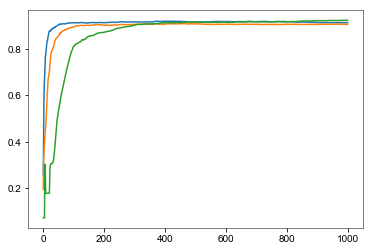

In [13]:
plt.plot(range(1000), net1_accuracy)
plt.plot(range(1000), net2_accuracy)
plt.plot(range(1000), net3_accuracy)